In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
predOmnPrflDF = pandas.read_csv("../data/omn_cplng_profile_cat.csv", index_col=0)
predOmnPrflDF["newell"] =  -1**(4/3)*numpy.power(numpy.abs(predOmnPrflDF["Vx"]),4./3) * numpy.power(predOmnPrflDF["B_T"], (2./3)) * (numpy.sin(predOmnPrflDF["theta_c"] / 2.))**(8./3)
predOmnPrflDF.head()

,Bz,Vx,By,delTimeOnset,pred_date,pred_type,theta_c,B_T,newell
0,-4.18,-471.6,-0.10,-108.0,2015-01-27 22:50:00,TP,3.163185,4.181196,-9525.722287
1,-4.00,-471.6,-1.09,-107.0,2015-01-27 22:50:00,TP,3.403185,4.145853,-9259.189012
2,-3.67,-472.8,-2.03,-106.0,2015-01-27 22:50:00,TP,3.643185,4.194020,-8800.616768
3,-4.78,-478.8,-1.25,-105.0,2015-01-27 22:50:00,TP,3.393185,4.940739,-10638.467386
4,-4.64,-478.8,-1.19,-104.0,2015-01-27 22:50:00,TP,3.393185,4.790167,-10421.212211


In [3]:
meanParamDF = predOmnPrflDF[\
                    ["Bz", "Vx", "By", "newell","delTimeOnset", "pred_type"]\
                    ].groupby( ["delTimeOnset", "pred_type"] ).mean().reset_index()
meanParamDF.columns = ["delTimeOnset", "pred_type", "mean_Bz", "mean_Vx", "mean_By", "mean_newell"]
stdParamDF = predOmnPrflDF[\
                    ["Bz", "Vx", "By", "newell", "delTimeOnset", "pred_type"]\
                    ].groupby( ["delTimeOnset", "pred_type"] ).std().reset_index()
stdParamDF.columns = ["delTimeOnset", "pred_type", "std_Bz", "std_Vx", "std_By", "std_newell"]
meanParamDF = pandas.merge( meanParamDF, stdParamDF, on=["delTimeOnset", "pred_type"] )
meanParamDF.head()

,delTimeOnset,pred_type,mean_Bz,mean_Vx,mean_By,mean_newell,std_Bz,std_Vx,std_By,std_newell
0,-120.0,FN,-0.094075,-425.697583,0.097218,-3375.135394,2.737739,81.498419,3.797702,2982.187490
1,-120.0,FP,-0.936080,-495.462302,0.699968,-5612.707850,3.616415,101.988021,4.444634,4760.894143
2,-120.0,TN,0.576982,-394.401163,0.023524,-2587.279346,2.947879,71.415640,3.697742,2483.556390
3,-120.0,TP,-0.897667,-524.128803,0.974046,-6166.955677,4.215549,105.177770,4.585725,5547.202352
4,-119.0,FN,-0.128501,-425.998936,0.037751,-3443.618767,2.744274,81.425284,3.877248,3032.483490


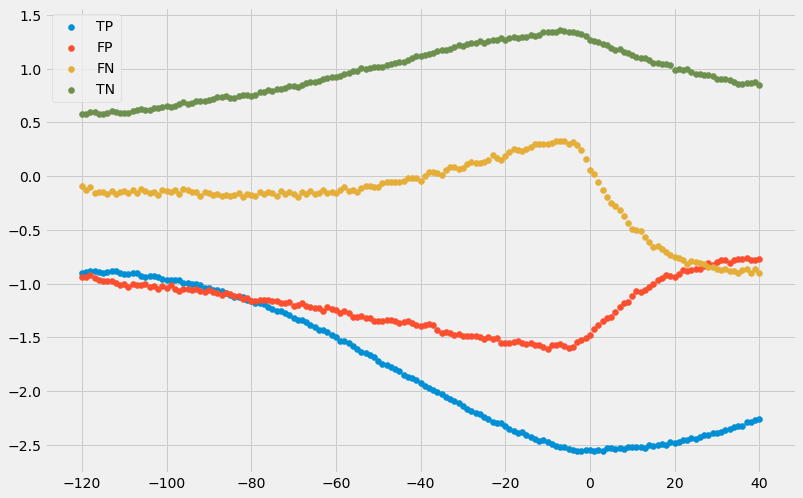

In [4]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

for _pd in predTypeList:
    selDF = meanParamDF[ meanParamDF["pred_type"] == _pd ]
    ax.scatter( selDF["delTimeOnset"].values, selDF["mean_Bz"].values, label=_pd )
#     ax.errorbar( selDF["delTimeOnset"].values, selDF["mean_Bz"].values,\
#                yerr=selDF["std_Bz"].values, label='', capthick=2., capsize=5., fmt='o')
plt.legend()
f.savefig("../plots/epoch_pred_types_Bz_mean.pdf")
f.savefig("../plots/epoch_pred_types_Bz_mean.eps")

In [5]:
# Bin by delTBins
delTBins = range(-120,40,10)
print delTBins
# get the min al in the next 30 min
oldColNames = predOmnPrflDF.columns.tolist()
predDF2 = pandas.concat( [ predOmnPrflDF, \
                    pandas.cut( predOmnPrflDF["delTimeOnset"], \
                               bins=delTBins ) ], axis=1 )
predDF2.columns = oldColNames + ["delT_bin"]
predDF2 = predDF2[ predDF2["pred_type"].isin([ "TP", "FP", "FN", "TN"]) ]

[-120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30]


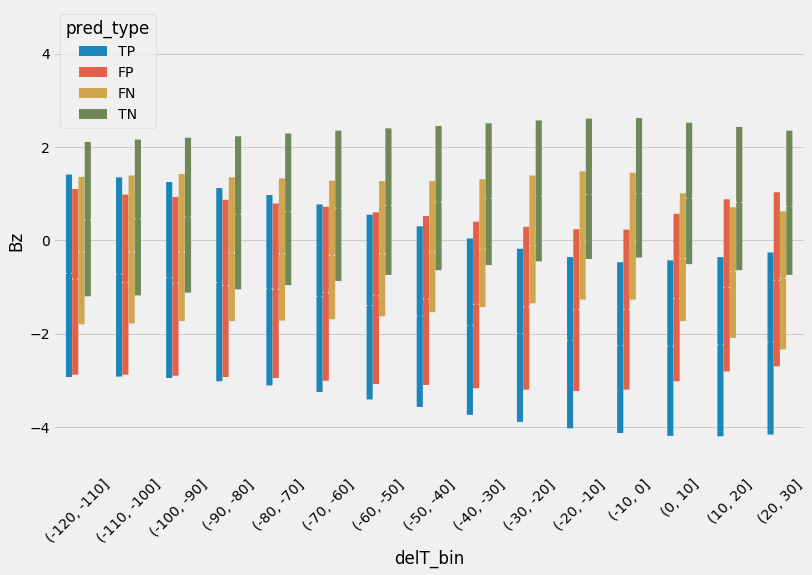

In [6]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

sns.boxplot(x="delT_bin", y="Bz", hue="pred_type", hue_order=predTypeList,\
                  data=predDF2, showfliers=False,ax=ax, linewidth=0.,\
            notch=True, width=0.5)

ax.set_ylim([-5,5])
plt.xticks(rotation=45)
f.savefig("../plots/epoch_pred_types_Bz_boxplot.pdf")
f.savefig("../plots/epoch_pred_types_Bz_boxplot.eps")

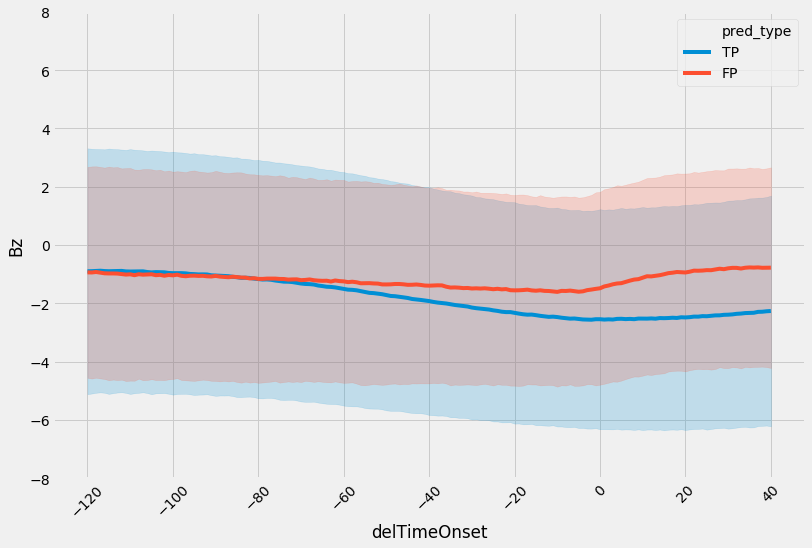

In [7]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

sns.lineplot(x="delTimeOnset", y="Bz", hue="pred_type", hue_order=predTypeList,\
                  data=predDF2, ci="sd", ax=ax)

ax.set_ylim([-8,8])
plt.xticks(rotation=45)
f.savefig("../plots/epoch_pred_types_Bz_boxplot.pdf")
f.savefig("../plots/epoch_pred_types_Bz_boxplot.eps")

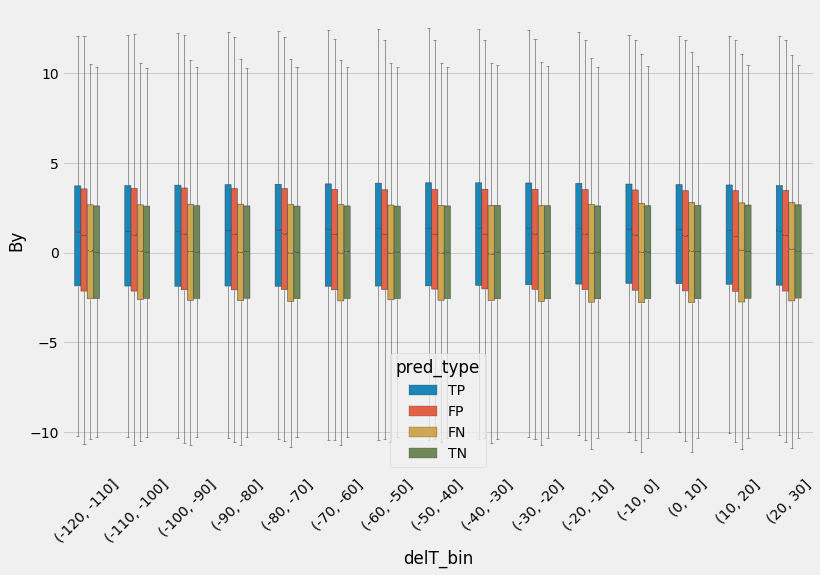

In [8]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

sns.boxplot(x="delT_bin", y="By", hue="pred_type", hue_order=predTypeList,\
                  data=predDF2, showfliers=False,ax=ax, linewidth=0.5,\
            notch=True, width=0.5)

# ax.set_ylim([-5,2])
plt.xticks(rotation=45)
f.savefig("../plots/epoch_pred_types_By_boxplot.pdf")
f.savefig("../plots/epoch_pred_types_By_boxplot.eps")